
### ARIMA and Seasonal ARIMA


#### Autoregressive Integrated Moving Averages

The general process for ARIMA models is the following:
* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model or Seasonal ARIMA based on the data
* Use the model to make predictions

Let's go through these steps!

### Importing Necessary Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

### Importing Data

In [2]:
df = pd.read_csv('perrin-freres-monthly-champagne-.csv')
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [3]:
df.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


The data appears to be from 1964 to 1972

### Feature Engineering

#### Dealing with null values

In [4]:
df.isnull().sum()

Month                                                     1
Perrin Freres monthly champagne sales millions ?64-?72    2
dtype: int64

Since there are only two null records out of 106 rows we will drop them.

In [5]:
print(len(df))
df.dropna(inplace = True)
print(len(df))

107
105


#### Converting Month into Datetime

In [6]:
df['Month'] = pd.to_datetime(df['Month'])
df

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0
...,...,...
100,1972-05-01,4618.0
101,1972-06-01,5312.0
102,1972-07-01,4298.0
103,1972-08-01,1413.0


#### Renaming Columns

In [7]:
df.columns = ['Month','Sales']
df

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0
...,...,...
100,1972-05-01,4618.0
101,1972-06-01,5312.0
102,1972-07-01,4298.0
103,1972-08-01,1413.0


#### Setting Month as Index

In [8]:
df.set_index('Month',inplace=True)

In [9]:
df

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
...,...
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0


In [10]:
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


### Data Visualization

#### Plotting Sales Trend

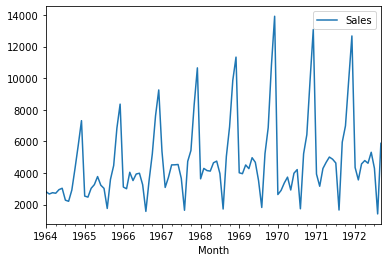

In [11]:
df.plot()

The data appears to be seasonal. At the begenning of the year, it starts with low sales and the sales start to peak near the end of the year. So may be the sales peak at winter and slows down in summer. Also we observe that sales every year is increasing and is higher than the previous year. Even though the data doesn't appear stationary, we will perform the test for stationarity.

#### Testing For Stationarity

A common assumption in many time series techniques is that the data are stationary.
A stationary process has the property that the mean, variance and autocorrelation structure do not change over time. Stationarity can be defined in precise mathematical terms, but for our purpose we mean a flat looking series, without trend, constant variance over time, a constant autocorrelation structure over time and no periodic fluctuations (seasonality).

We will be using  Augmented Dickey-Fuller test to check the stationarity of the data.

In [12]:
test_result = adfuller(df['Sales'])
test_result

(-1.8335930563276184,
 0.36391577166024713,
 11,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 1478.4633060594724)

In [13]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("We have a strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("We have a weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [14]:
adfuller_test(df['Sales'])

ADF Test Statistic : -1.8335930563276184
p-value : 0.36391577166024713
#Lags Used : 11
Number of Observations Used : 93
We have a weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#### Differencing

Since the data is non-stationary, we need to make it stationary. In order to do that we will be using differencing.

If the time series is not stationary, we can often transform it to stationarity with one of the differencing technique given below.

1. We can difference the data. That is, given the series Zt, we create the new series
                                           Yi = Zt - Zt-1     
   The differenced data will contain one less point than the original data. Although you can difference the data more than 
   once, one difference is usually sufficient.
   

2. If the data contain a trend, we can fit some type of curve to the data and then model the residuals from that fit. Since the 
   purpose of the fit is to simply remove long term trend, a simple fit, such as a straight line, is typically used.


3. For non-constant variance, taking the logarithm or square root of the series may stabilize the variance. For negative data, 
   you can add a suitable constant to make all the data positive before applying the transformation. This constant can then be    subtracted from the model to obtain predicted (i.e., the fitted) values and forecasts for future points.The above techniques    are intended to generate series with constant location and scale. Although seasonality also violates stationarity, this is      usually explicitly incorporated into the time series model.

In [15]:
df['Sales'].shift(1)

Month
1964-01-01       NaN
1964-02-01    2815.0
1964-03-01    2672.0
1964-04-01    2755.0
1964-05-01    2721.0
               ...  
1972-05-01    4788.0
1972-06-01    4618.0
1972-07-01    5312.0
1972-08-01    4298.0
1972-09-01    1413.0
Name: Sales, Length: 105, dtype: float64

In [16]:
df['SalesFirstDiff'] = df['Sales'] - df['Sales'].shift(1)
df

,Sales,SalesFirstDiff
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,-143.0
1964-03-01,2755.0,83.0
1964-04-01,2721.0,-34.0
1964-05-01,2946.0,225.0
...,...,...
1972-05-01,4618.0,-170.0
1972-06-01,5312.0,694.0
1972-07-01,4298.0,-1014.0


Since our data is seasonal and we have 12 months of data, so data per year is divided into 12 chuncks so we shif the data by 12 places.

In [17]:
df['SeasonalFirstDiff'] = df['Sales']-df['Sales'].shift(12)
df

,Sales,SalesFirstDiff,SeasonalFirstDiff
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
...,...,...,...
1972-05-01,4618.0,-170.0,-392.0
1972-06-01,5312.0,694.0,438.0
1972-07-01,4298.0,-1014.0,-335.0


Now to check if the data is stationary, we will be applying the Augmented Dickey Fueler test to the SeasonalFIrstDiff column.

#### Applying the Augmented Dickey Fueler Test to the differenciated data

In [18]:
adfuller_test(df['SeasonalFirstDiff'].dropna())

ADF Test Statistic : -7.626619157213164
p-value : 2.060579696813685e-11
#Lags Used : 0
Number of Observations Used : 92
We have a strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


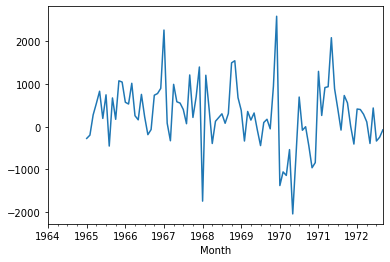

In [19]:
df['SeasonalFirstDiff'].plot()

 Now we can safely say that the data is stationary and non seasonal

### Auto Regressive Model

#### Autocorrelation and Partial Autocorrelation

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.
    
    p,d,q
    
    p -  AR model lags
    
    d -  differencing
    
    q -  MA lags

    MA - Moving Average
 

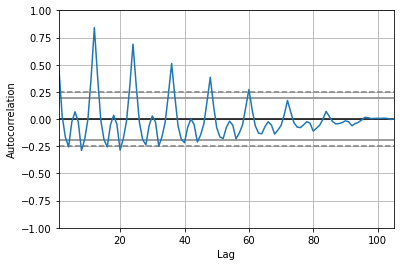

In [20]:
autocorrelation_plot(df['Sales'])
plt.show()

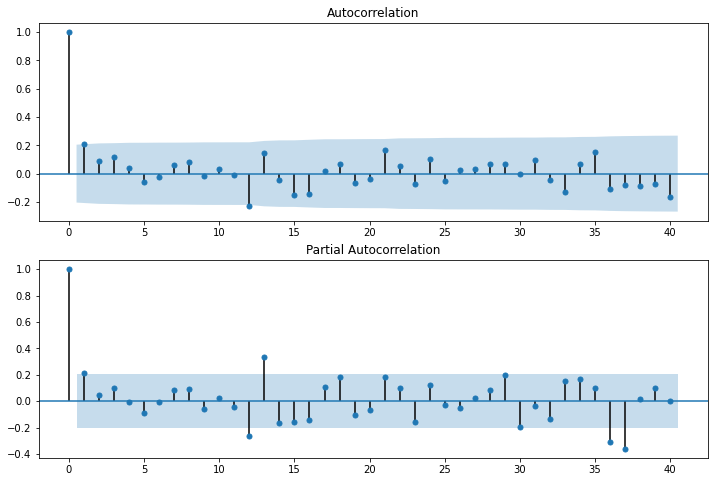

In [21]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['SeasonalFirstDiff'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['SeasonalFirstDiff'].iloc[13:],lags=40,ax=ax2)

### Constructing ARIMA Model

For non-seasonal data
p = 1, d = 1, q = 0 or 1

#### Applying the ARIMA Model

In [22]:
model = ARIMA(df['Sales'],order=(1,1,1))
model_fit = model.fit()
model_fit.summary()

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.126
Method:                       css-mle   S.D. of innovations           2227.262
Date:                Wed, 01 Dec 2021   AIC                           1910.251
Time:                        10:55:31   BIC                           1920.829
Sample:                    02-01-1964   HQIC                          1914.536
                         - 09-01-1972                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.7834     12.405      1.837      0.066      -1.530      47.097
ar.L1.D.Sales     0.4343      0.089      4.866      0.000       0.259       0.609
ma.L1.D.Sales    -1.0000      0.026    -38.503      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3023           +0.0000j            2.3023            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

#### Forcasting using ARIMA Model

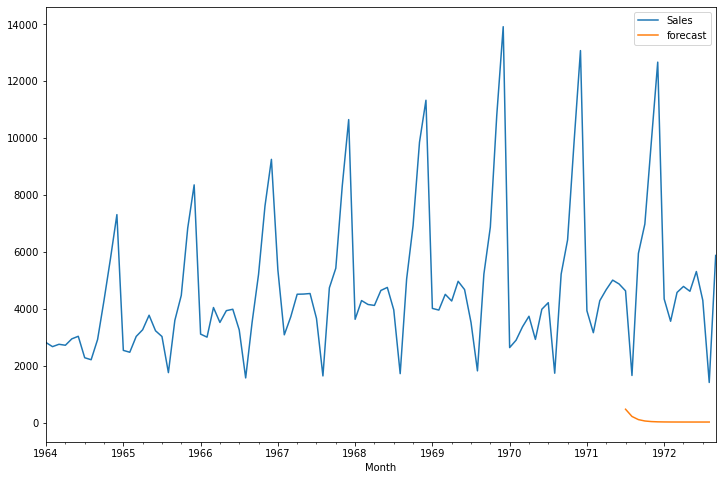

In [23]:
df['forecast'] = model_fit.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

ARIMA is meant to be run on non-seasonal data. Since our data is seasonal in nature, we see that ARIMA does a really bad job of forecasting the data as seen in the plot above.
To fix this we will be constructing a Seasonal ARIMA or SARIMAX model.

### Constructing SARIMAX Model

#### Applying SARIMAX model

In [24]:
model = sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results  = model.fit()
results.summary()

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -738.402
Date:                            Wed, 01 Dec 2021   AIC                           1486.804
Time:                                    10:55:32   BIC                           1499.413
Sample:                                01-01-1964   HQIC                          1491.893
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.081      3.433      0.001       0.120       0.438
ma.L1         -0.9494      0.043    -22.334      0.000      -1.033      -0.866
ar.S.L12      -0.4544      0.303     -1.499      0.134      -1.049       0.140
ma.S.L12       0.2450      0.311      0.788      0.431      -0.365       0.855
sigma2      5.055e+05   6.12e+04      8.265      0.000    3.86e+05    6.25e+05
===================================================================================
Ljung-Box (Q):                       40.24   Jarque-Bera (JB):                 8.70
Prob(Q):                              0.46   Prob(JB):                         0.01
Heteroskedasticity (H):               1.18   Skew:                            -0.21
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Forcasting using SARIMAX Model

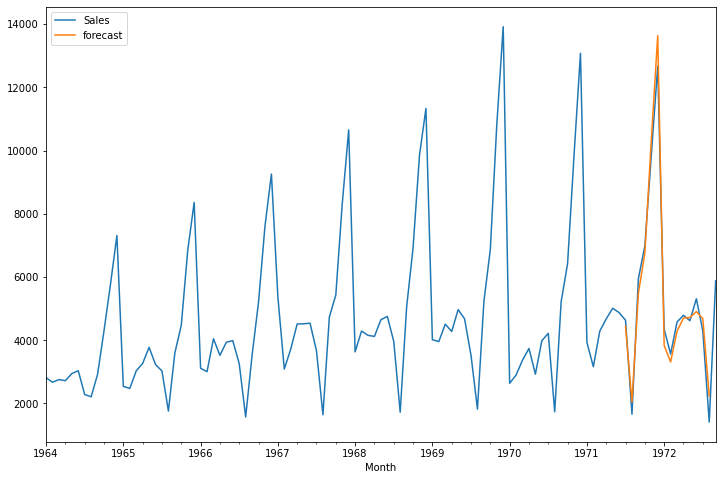

In [25]:
df['forecast'] = results.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

When we look at the SARIMAX model results, we see it does a good job of forecasting for test dataset. Now we will be forecasting future data beyond 1972.

#### Future Forecasting

In [26]:
future_dates = [df.index[-1]+ DateOffset(months = x)for x in range(0,24)]
future_datest_df = pd.DataFrame(index = future_dates[1:],columns = df.columns)
future_datest_df.tail()

,Sales,SalesFirstDiff,SeasonalFirstDiff,forecast
1974-04-01,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN


In [27]:
future_df = pd.concat([df,future_datest_df])
future_df

,Sales,SalesFirstDiff,SeasonalFirstDiff,forecast
1964-01-01,2815.0,NaN,NaN,NaN
1964-02-01,2672.0,-143.0,NaN,NaN
1964-03-01,2755.0,83.0,NaN,NaN
1964-04-01,2721.0,-34.0,NaN,NaN
1964-05-01,2946.0,225.0,NaN,NaN
...,...,...,...,...
1974-04-01,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Future Forecasting')

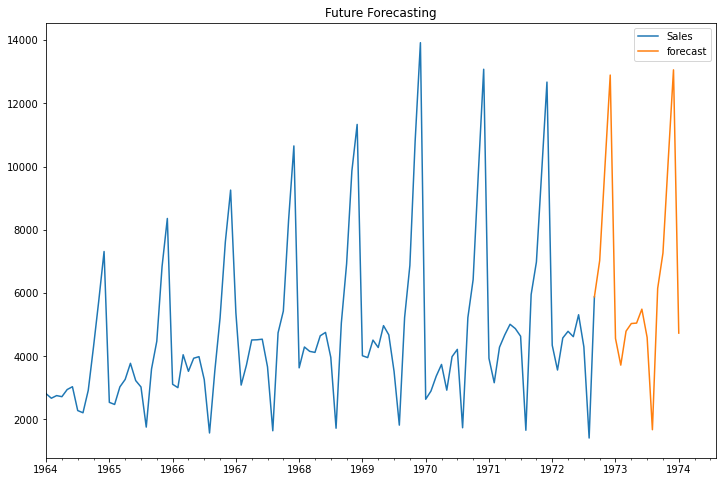

In [28]:
future_df['forecast'] = results.predict(start = 104, end = 120, dynamic = True)  
future_df[['Sales', 'forecast']].plot(figsize =(12, 8))
plt.title("Future Forecasting")